# Music Genre Classification

### Clark Brown, Sam Cochran, Daniel Swingle
#### Brigham Young University

#### October 26, 2020

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
from models import logistic_regression
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 96

## 1. Introduction

Intro text that the reader finds informative.

### 1.1 Motivation

Questions we want to answer:

1. What features of music make it a part of its genre?

### 1.2 Literary Review

People have done this before, isn't that neat?

## 2. Data

Our data comes from the Free Music Archive ([​https://github.com/mdeff/fma]​) reated by Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson. International Society for Music Information Retrieval Conference (ISMIR), 2017.

We use the audio files and genre tags, but build our own features. We also use the ​small​ data set composed of 8000 30-second songs (8 GB in `.mp3` fromat). We convert each file to a `.wav` for simplicity. Each song is designated by a `track_id` and labeled with one of eight genres: Hip-Hop, Pop, Folk, Experimental, Rock, International, Electronic, and Instrumental. There songs are distributed evenly across genres with 1000 songs per genre.

### 2.1 Potential Issues

One potential issue with our data is that the dataset is composed entirely of free music (creative commons), and therefore our model may have difficulty analyzing other kinds of music, which may be quite different.

Specifically, we have reason to believe that the genre definitions, quality, and style of a free music database may differ from commercial music, so we will have to find a way to evaluate how well a model trained on a free music database can generalize to samples of commercial music

### 2.2 Missing Data

The dataset is fairly robust, but of the 8000 tracks, there are 6 that are not actually 30 seconds long. We ignore these tracks from our analysis.

## 3. Ethical Concerns and Implications

This is a discussion of ethics.

## 4. Feature Engineering

Since our original data was made up only of track IDs corresponding to wav files, and their genre labels, our feature extraction makes up all of our useful data. We created a dataframe that has the following features as its columns. In the next section, we discuss the meaning of each added feature column.

### 4.1 Feature Descriptions and Reasoning

**Track ID**: each wav file corresponds to a number, and we have a function that generates the file path to access each track if needed.
Genre Code: We have encoded our eight genres by a 1:1 mapping to integers 0-7.

**Zero Crossing Rate**: Indicates the average rate at which the sign of the signal changes. Higher zero crossing rates match with higher percussiveness in the song. We added this feature because genres often have a certain feel relative to beat and percussive sound.

**Frequency Range**: The max and min frequency the audio ignoring the top 20% and bottom 20%. Clipping the top and bottom was important because almost all of our audio files go from 10 Hz to 10000 Hz. But seeing the range in where most of the sound of a song is seems to be connected to genre. Some genres have greater ranges while others are in a small range.

**Key and Tonality**: We used the Krumhansl-Schmuckler algorithm to estimate the most likely key that the audio sample is in, and whether the key is major or minor. We chose this because even though most genres have songs in different keys, knowing the key will aid in normalizing pitch information for other features.

**Mel Frequency Cepstral Coefficients (MFCCs)**: Represents the short term power spectrum of the sound. Aligns closely with the human auditory system’s reception of sound. These 6 (for now) coefficients describe the sound of a song in a human way. MFCCs are being used more and more in Music Information Retrieval specifically with genre tasks because they encapsulate the human experience of sound. We feel this will improve accuracy.

**Spectral Rolloff**: The frequency below which a certain percent of the total spectral energy (pitches) are contained. When audio signals are noisy, the highest and lowest pitches present do not convey much information. What is more useful is knowing the frequency range that 99% of the signal is contained in, which is what the spectral rolloff represents.

**The Three Highest Tempo Autocorrelation Peaks**: Indicative of what we would guess the average BPM will be for this audio file (3 columns).  This is a way of summing up the entire tempogram array in just a few numbers so that comparing tempo features for each track is tractable.

**Average Tonnetz over all Time**: The mean and variance of the x and y dimensions of the tonal centers for the major and minor thirds, as well as the fifths (this ends up being 6 means and 6 variances for a total of 12 columns).  Here we take the means and variances to reduce the information down from a 6xt matrix (where t is the number of time values, about 1200) to just 12 numbers that sum up that matrix for each track.


## 5. Visualization and Analysis

### 5.1 Visualization

In [4]:
genres = [
    "Hip-Hop",
    "Pop",
    "Folk",
    "Experimental",
    "Rock",
    "International",
    "Electronic",
    "Instrumental",
]

df = pd.read_csv('../data/features.csv', header=0, index_col=0)
df['genre'] = df.genre_code.apply(lambda x : genres[x])

In [5]:
df[['zcr', 'genre']].groupby('genre').boxplot(column='zcr', grid=False, figsize=(11,11))
plt.suptitle('Zero Crossing Rate Distribution by Genre')
plt.show()

KeyError: "['zcr'] not in index"

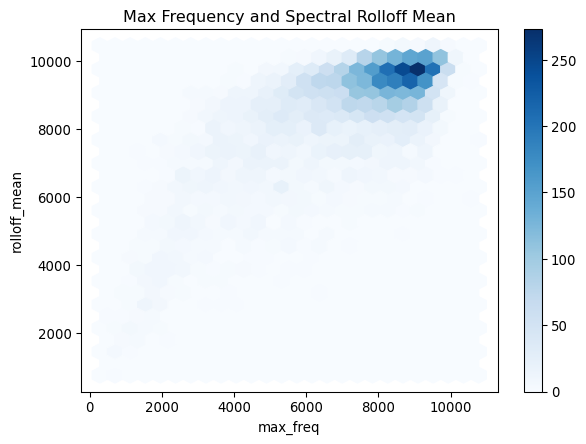

In [6]:
df.plot(kind='hexbin', x='max_freq', y='rolloff_mean', gridsize=25, figsize=(7, 5), cmap='Blues', sharex=False)
plt.title('Max Frequency and Spectral Rolloff Mean')
plt.show()

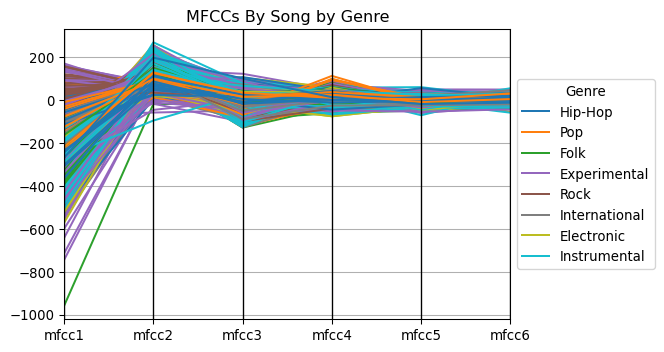

In [7]:
mfcc_cols = [f'mfcc{i}' for i in range(1,7)]
plt.figure()
parallel_coordinates(df[mfcc_cols + ['genre']], 'genre', colormap='tab10')
plt.title('MFCCs By Song by Genre')
plt.legend(title='Genre', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [8]:
#map an index 0-11 to a key
keys = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def map_key(is_major: bool, index: int) -> str:
    return keys[index] + " " + ("major" if is_major else "minor")

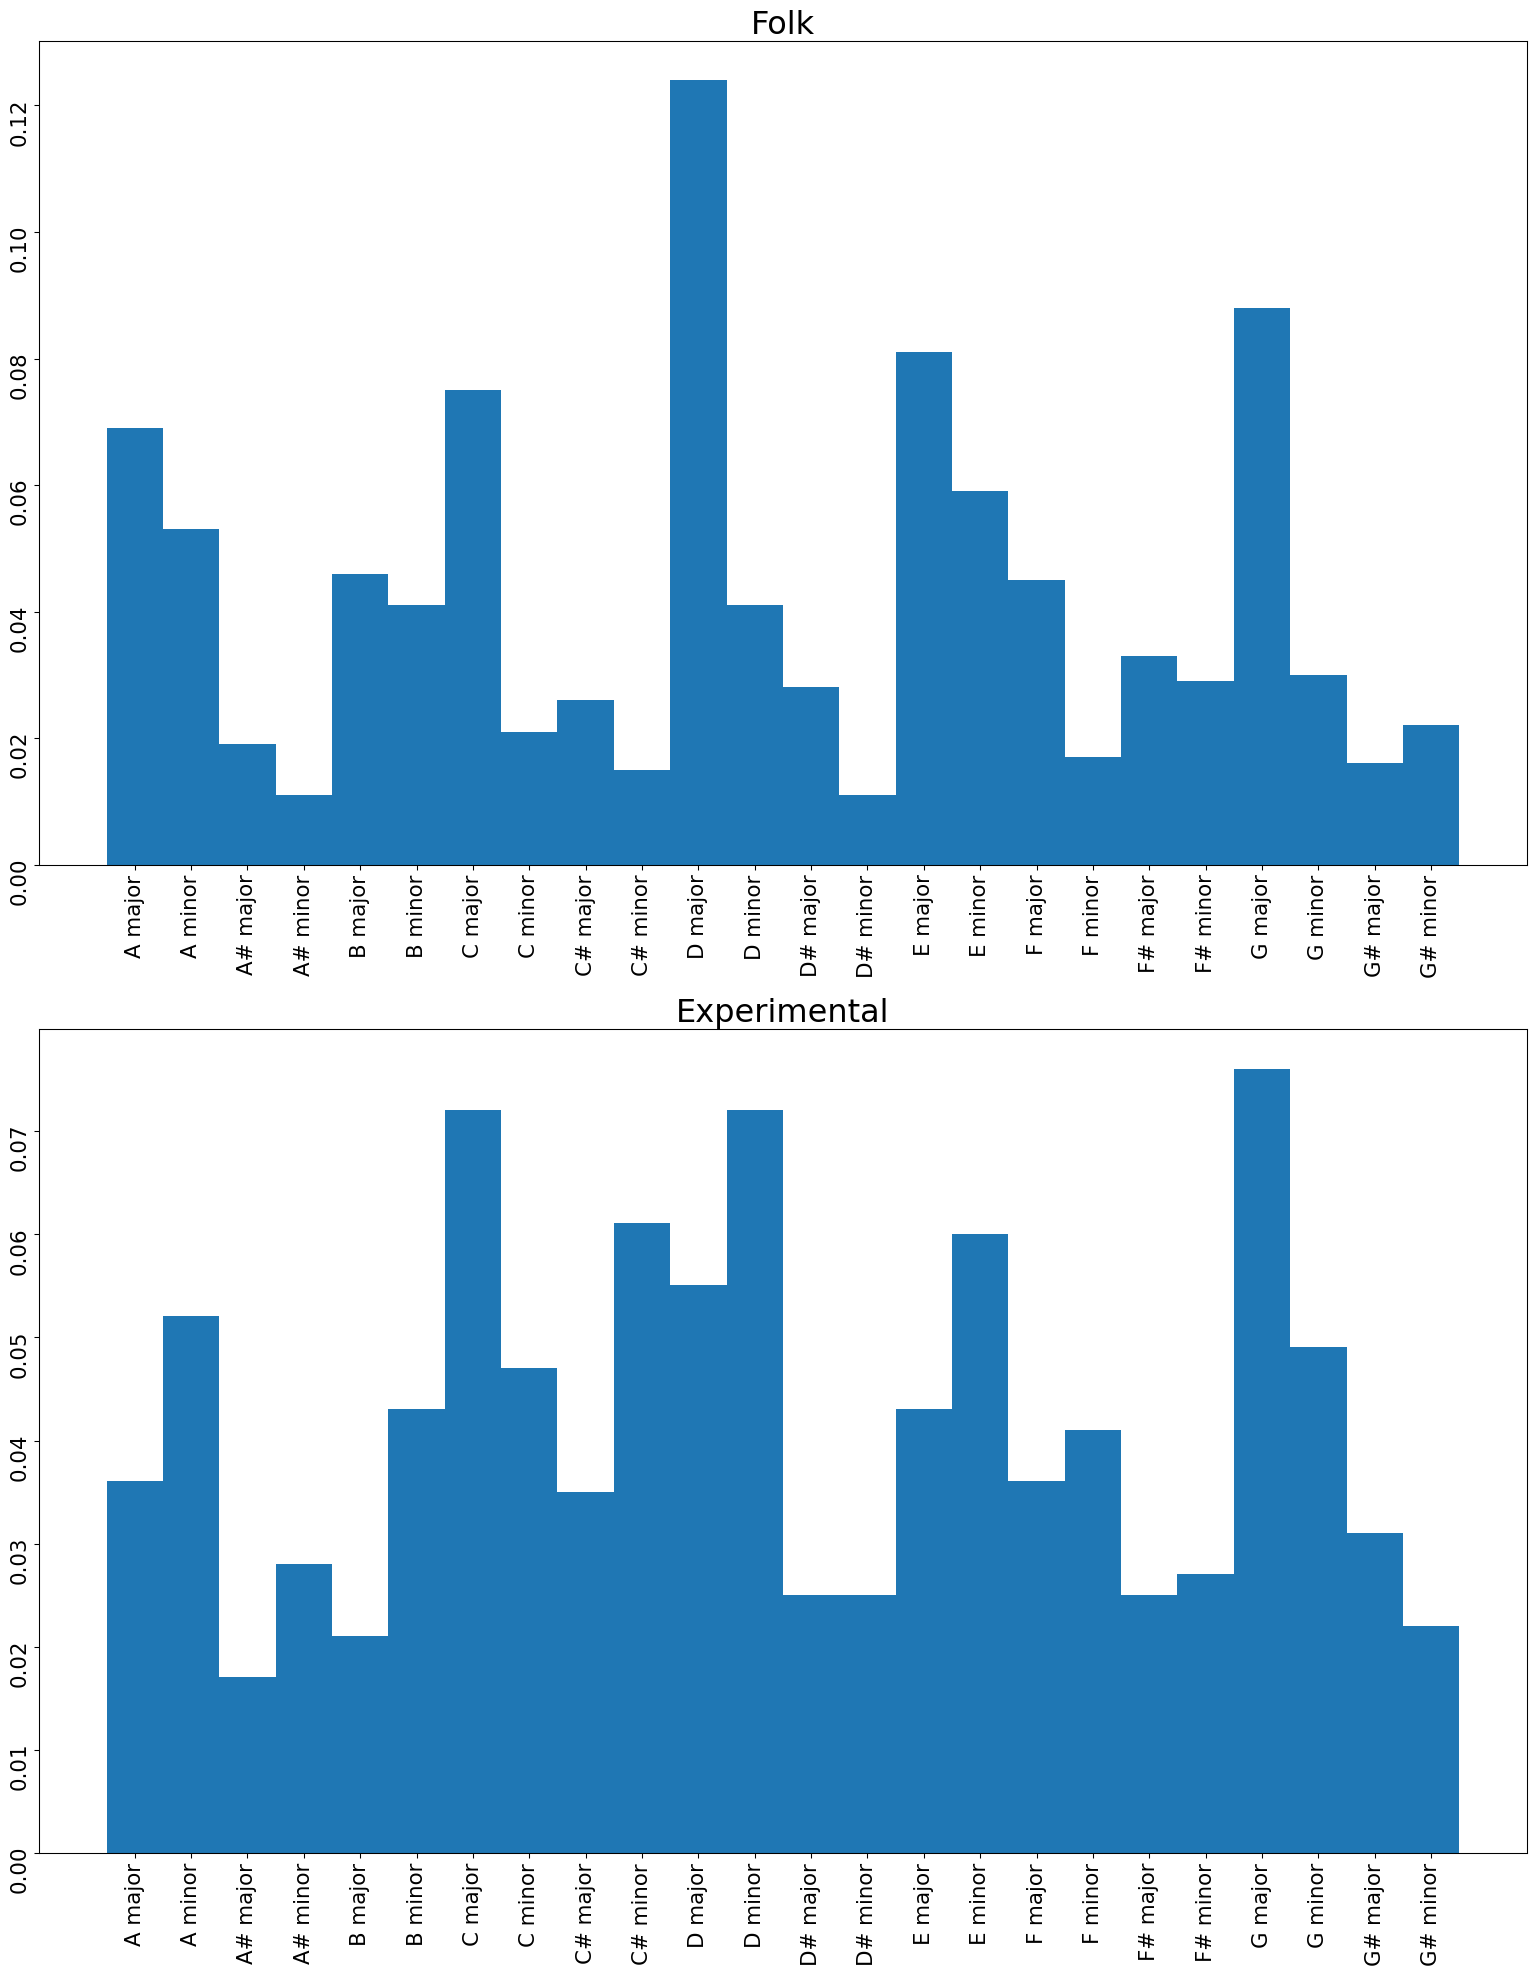

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(20, 25))
ax = ax.ravel()
bins = np.arange(25) - 0.5

for i in range(2):
    features = df[df["genre_code"] == (i+2)]
    
    key = features["key"]
    major = features["major"]
    sig = np.array([
        map_key(bool(m), int(k)) for m, k in zip(major, key)
    ])
    sig = np.sort(sig)
    
    ax[i].hist(sig, density=True, bins=bins)
    ax[i].set_title(genres[i+2], size=24)
    ax[i].tick_params(labelrotation=90, labelsize=16)

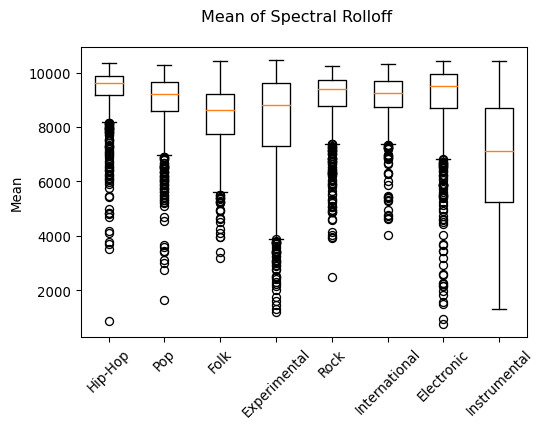

In [10]:
import warnings
warnings.filterwarnings("ignore",
                        category=np.VisibleDeprecationWarning)

rolloff_mean = df["rolloff_mean"]

plt.boxplot([
    rolloff_mean[df["genre_code"] == i] for i in range(len(genres))
], labels=genres)
plt.suptitle("Mean of Spectral Rolloff")
plt.ylabel("Mean")
plt.xticks(rotation=45)
plt.show()

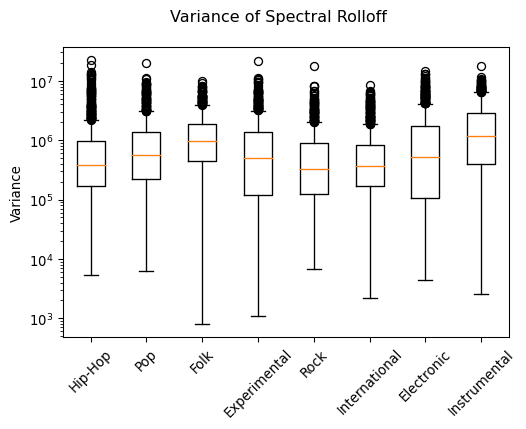

In [11]:
rolloff_var = df["rolloff_var"]

plt.yscale("log")
plt.boxplot([
    rolloff_var[df["genre_code"] == i] for i in range(len(genres))
], labels=genres)
plt.suptitle("Variance of Spectral Rolloff")
plt.ylabel("Variance")
plt.xticks(rotation=45)
plt.show()

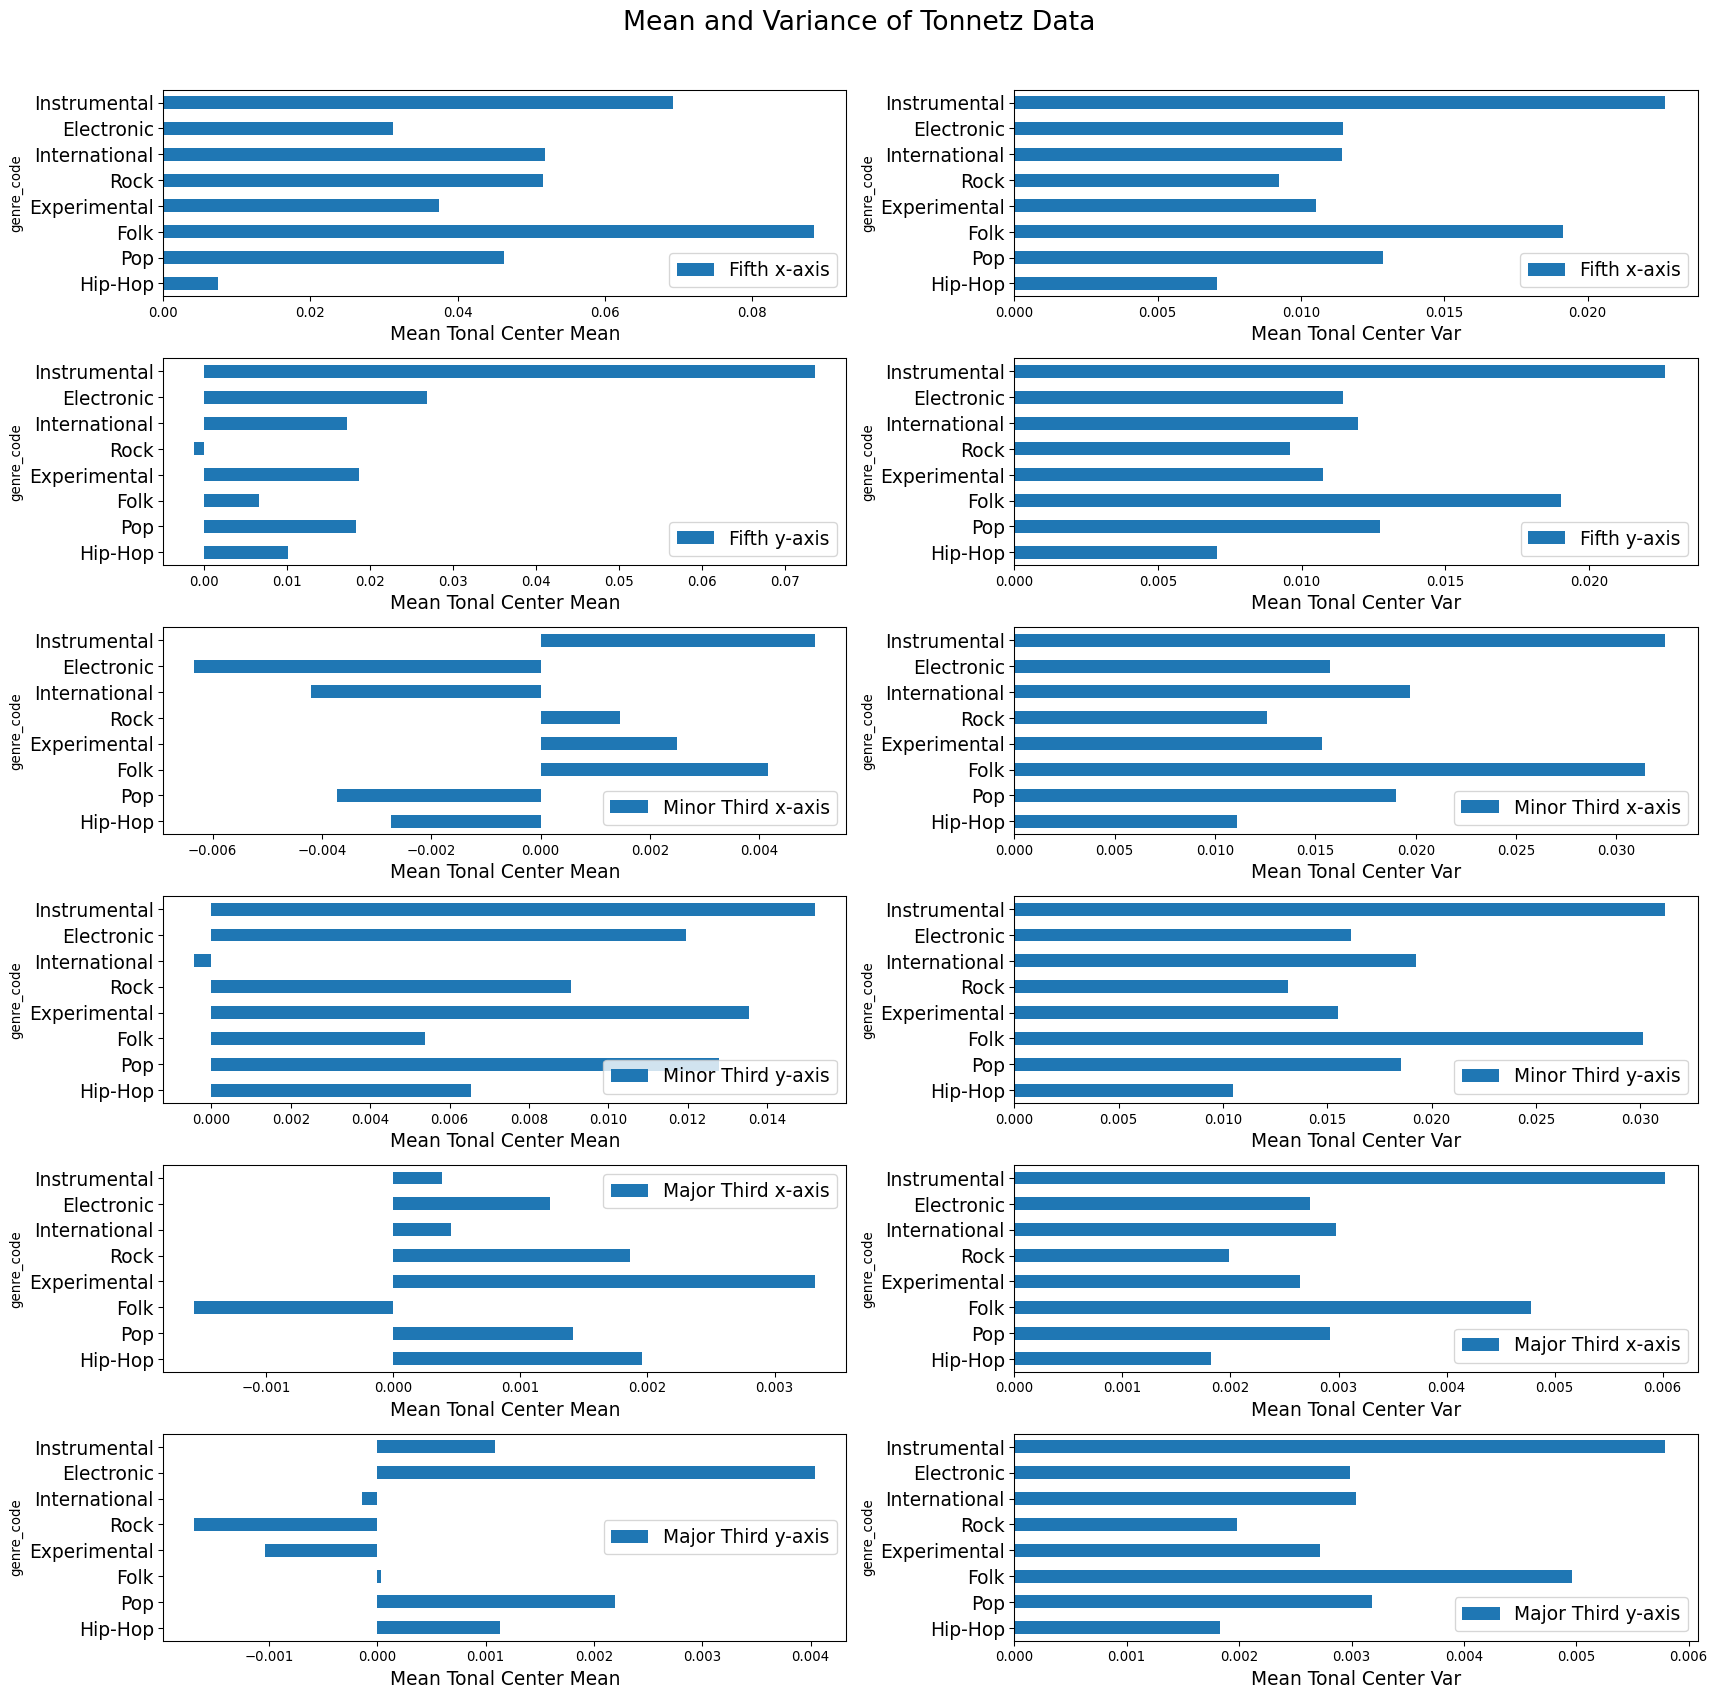

In [30]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18, 18

# Load the data and get the labels
data = pd.read_csv('./../data/features.csv')

# Save the genre labels
genre_labels = ["Hip-Hop", "Pop", "Folk", "Experimental", "Rock", "International", "Electronic", "Instrumental"]
tonnetz_labels = ['Fifth x-axis', 'Fifth y-axis', 'Minor Third x-axis', 'Minor Third y-axis', 'Major Third x-axis', 'Major Third y-axis']

# Get the tonnetz features in their own dataframe and group by genre
tonnetz_features = data[['genre_code', 'tonnetz1', 'tonnetz2', 'tonnetz3', 'tonnetz4', 'tonnetz5', 'tonnetz6', 'tonnetz7', 'tonnetz8', 'tonnetz9', 'tonnetz10', 'tonnetz11', 'tonnetz12']]    
group = tonnetz_features.groupby('genre_code')

# Make some bar plots
fig1, axes1 = plt.subplots(6, 2)
for k in range(12):
    group.mean()['tonnetz' + str(k+1)].plot(kind='barh', ax=axes1.reshape(-1)[k], legend=True)
    axes1.reshape(-1)[k].set_yticks([x for x in range(8)])
    axes1.reshape(-1)[k].set_yticklabels(genre_labels, fontsize=14)
    if k % 2 == 0:
        axes1.reshape(-1)[k].set_xlabel('Mean Tonal Center Mean', fontsize=14)
        axes1.reshape(-1)[k].legend([tonnetz_labels[k//2]], fontsize=14)
    else:
        axes1.reshape(-1)[k].set_xlabel('Mean Tonal Center Var', fontsize=14)
        axes1.reshape(-1)[k].legend([tonnetz_labels[k//2]], fontsize=14)
    
plt.suptitle('Mean and Variance of Tonnetz Data\n\n', fontsize=20)
plt.tight_layout()
plt.show()


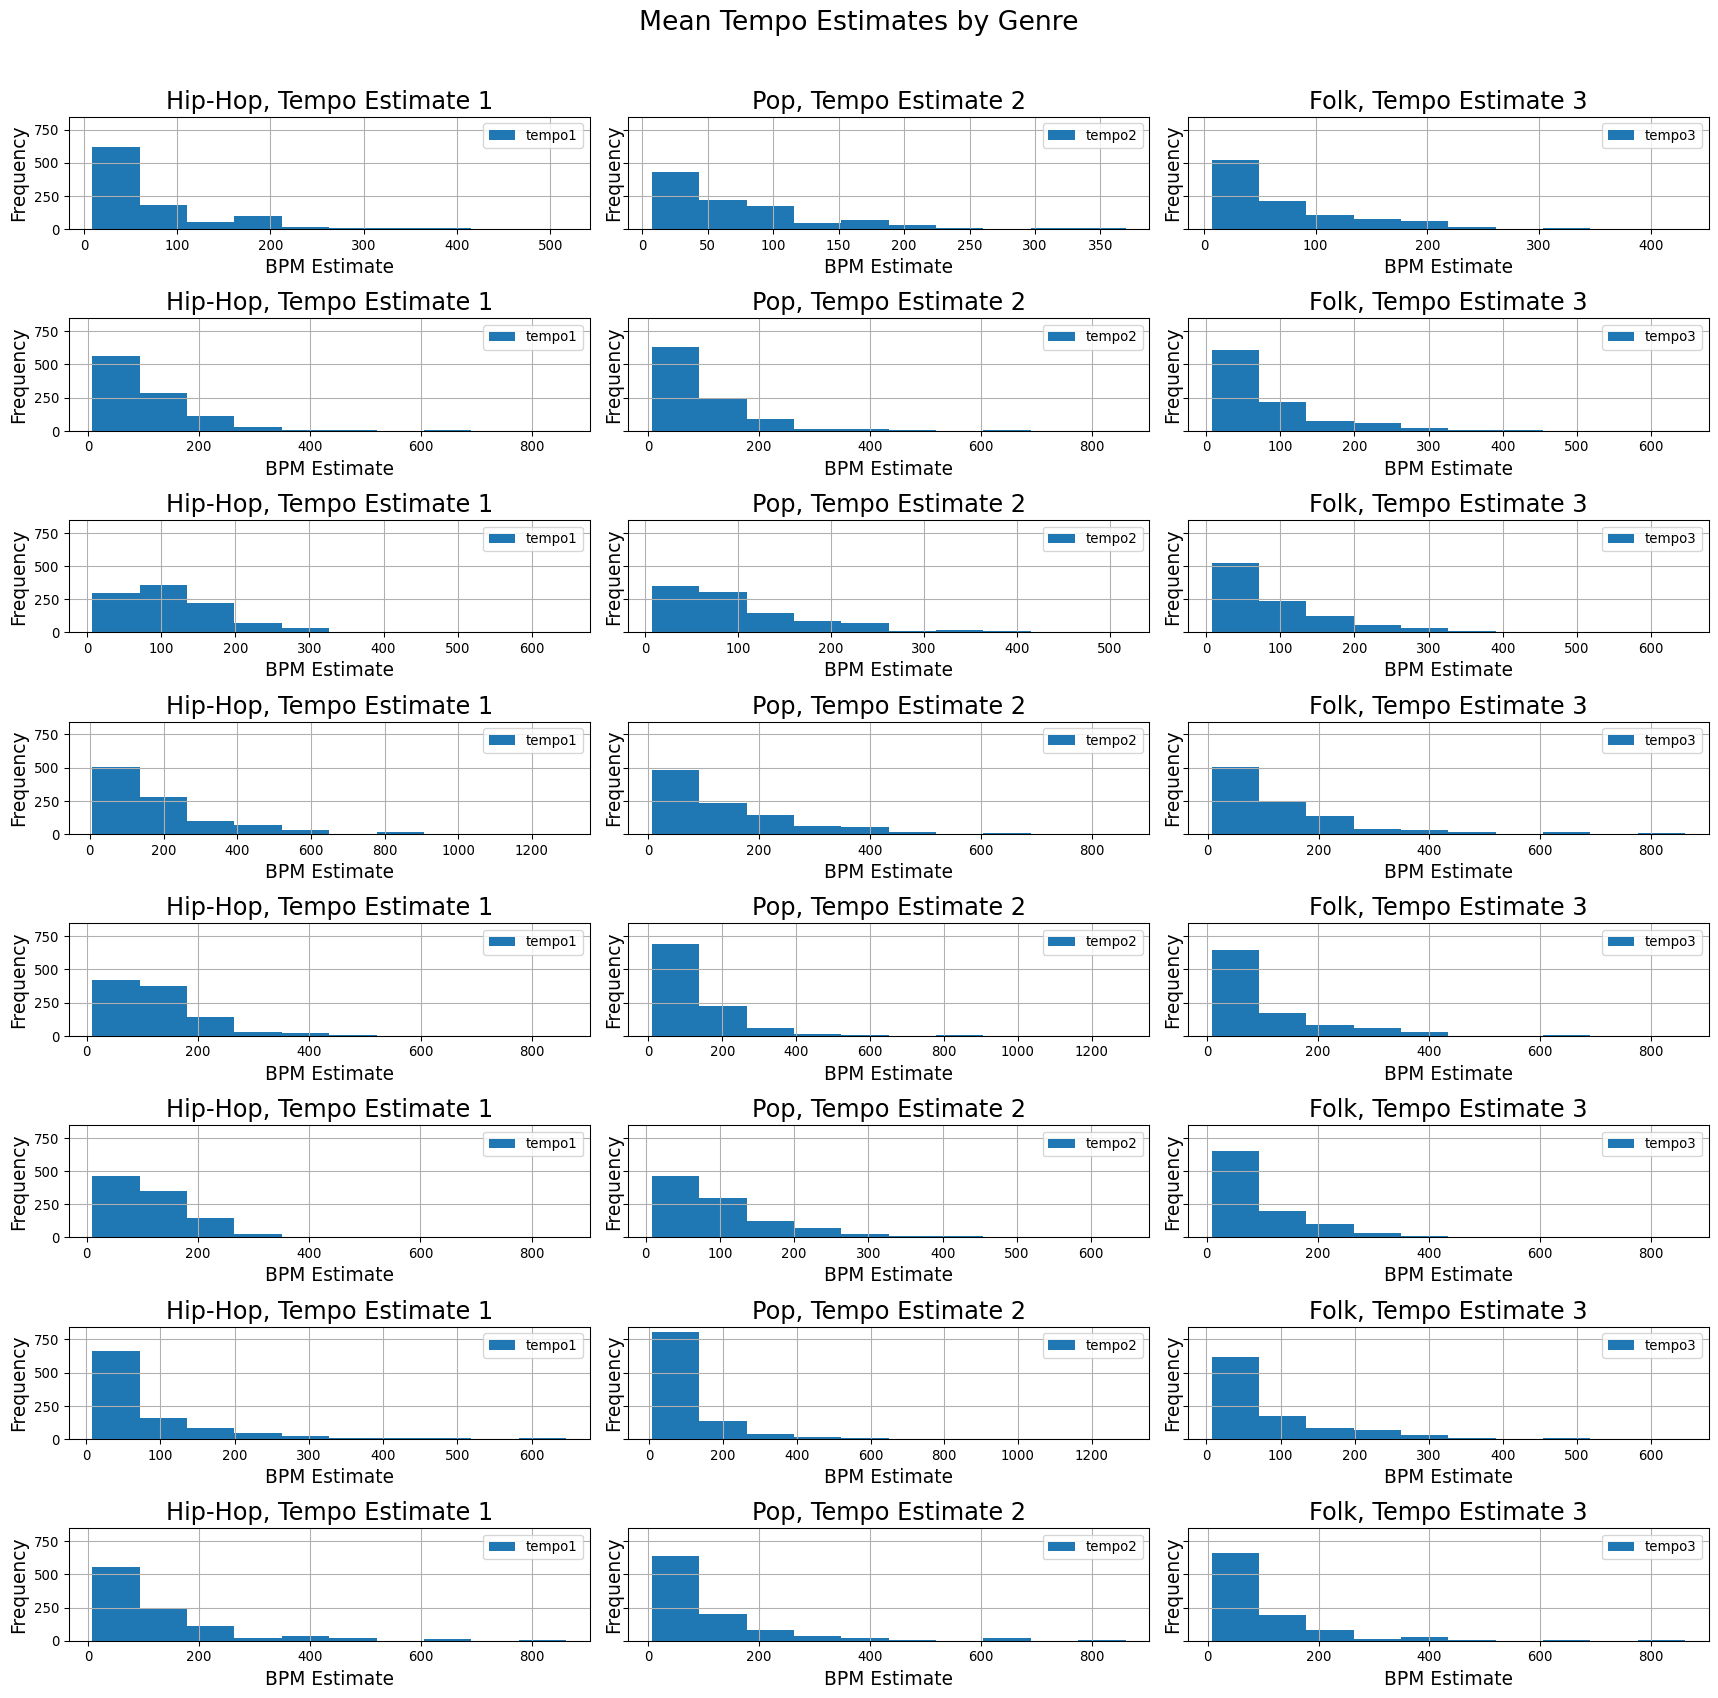

In [31]:
# Get the tempo features in their own dataframe
tempo_features = data[['genre_code', 'tempo1', 'tempo2', 'tempo3']]

# Group by genre
group = tempo_features.groupby('genre_code')

# Make a density plot
fig2, axes2 = plt.subplots(8, 3, sharey=True)
for j in range(8):
    for k in range(3):
        group.get_group(j).hist(column='tempo'+str(k+1), ax=axes2[j, k], legend=True)
        axes2[j, k].set_xlabel('BPM Estimate', fontsize=14)
        axes2[j, k].set_ylabel('Frequency', fontsize=14)
        axes2[j, k].set_title(genre_labels[k] + ', Tempo Estimate ' + str(k+1), fontsize=18)
        
plt.suptitle('Mean Tempo Estimates by Genre\n\n', fontsize=20)
plt.tight_layout()
plt.show()


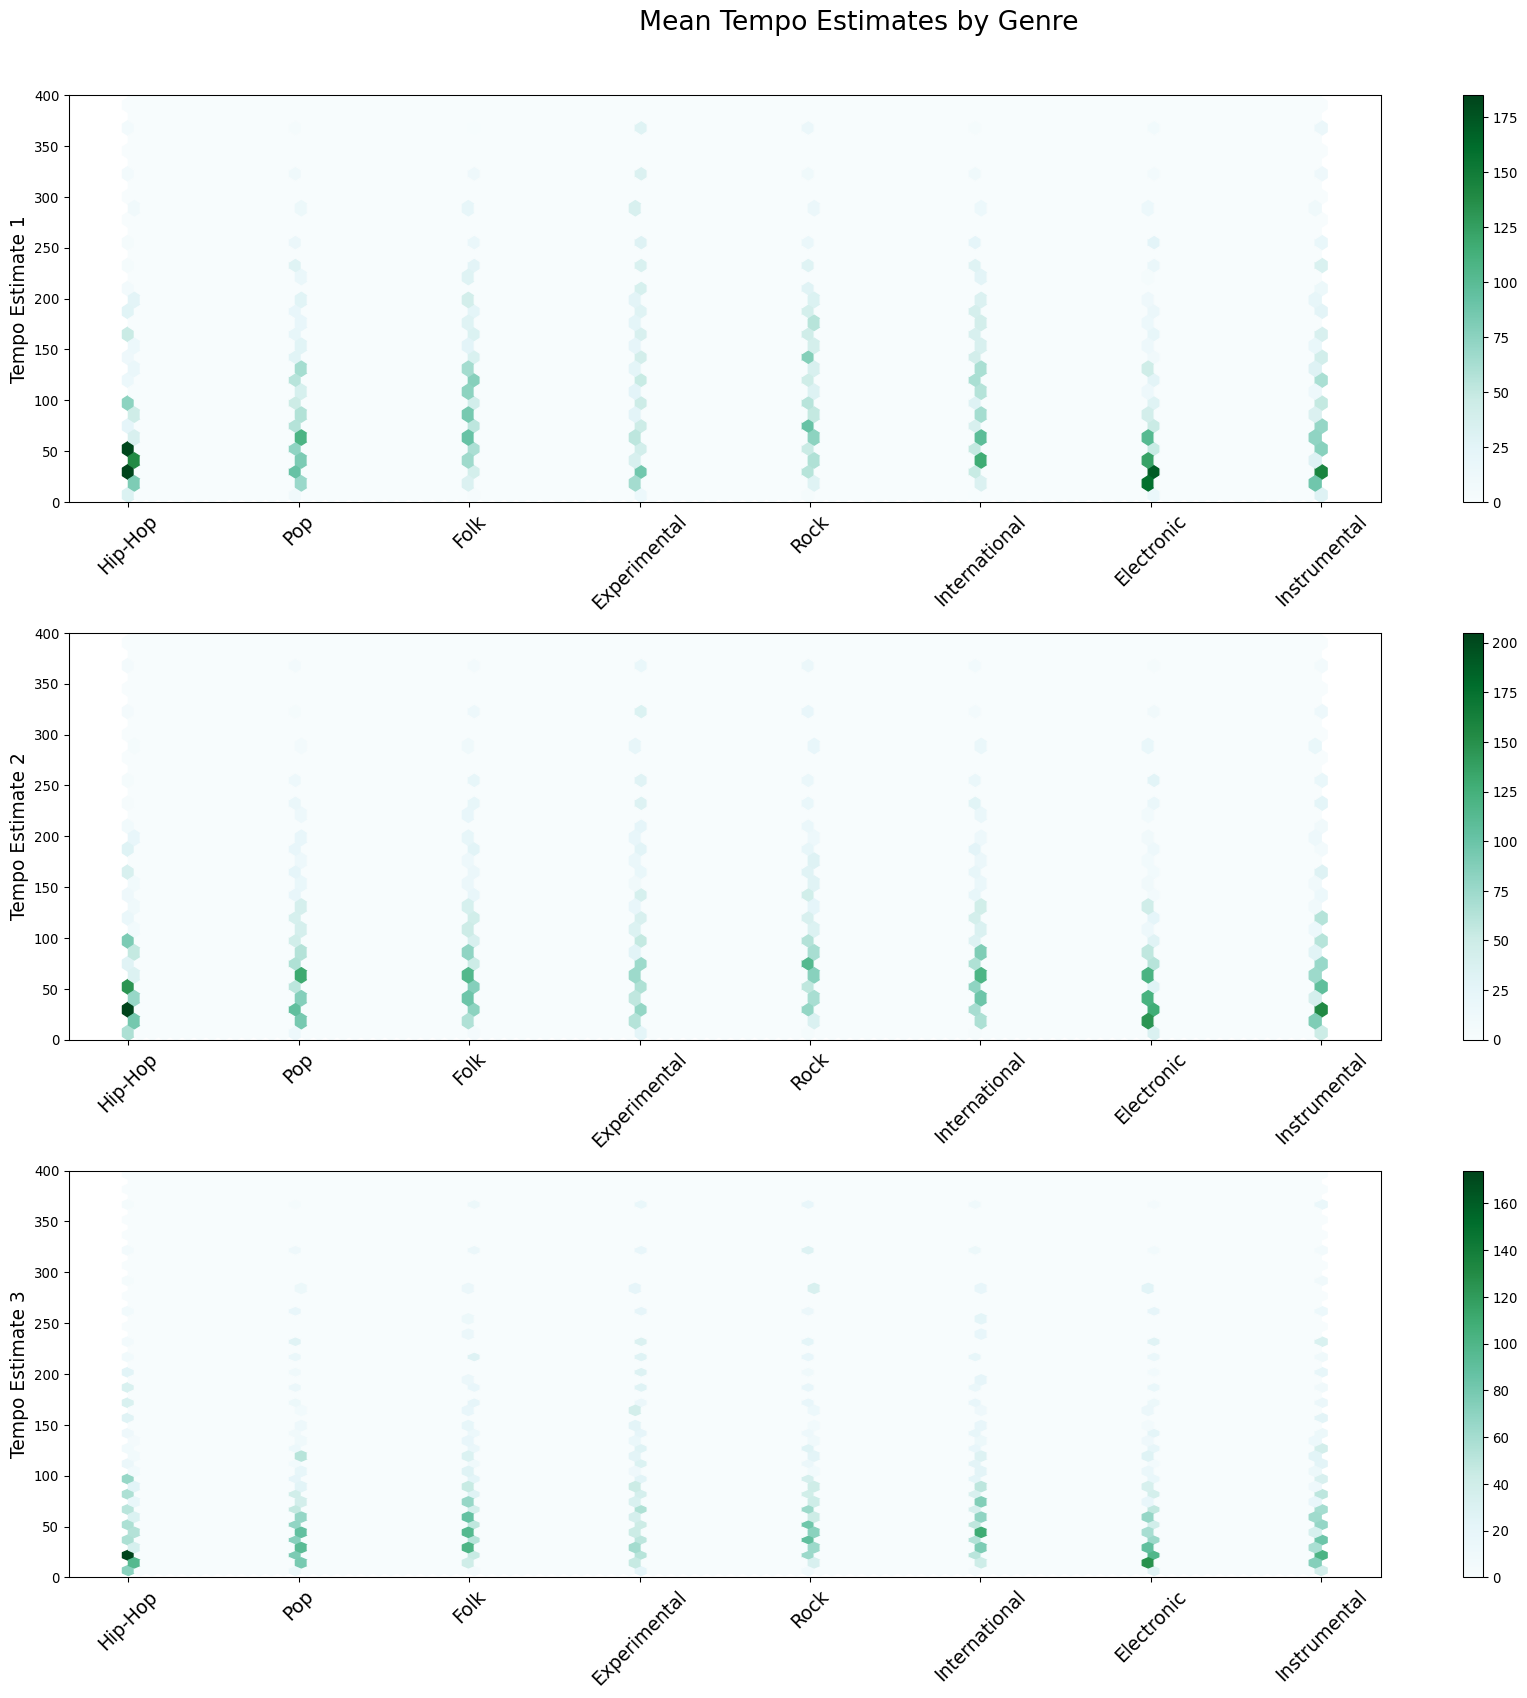

In [32]:
# Make a hexbin
fig3, axes3 = plt.subplots(3, 1)
for k in range(3):
    tempo_features.plot(ylim=[0, 400], x='genre_code', y='tempo'+str(k+1), kind='hexbin', ax=axes3[k])
    axes3[k].set_xticks([x for x in range(8)])
    axes3[k].set_xticklabels(genre_labels, rotation=45, fontsize=14)
    axes3[k].set_ylabel('Tempo Estimate ' + str(k+1), fontsize=14)
    axes3[k].set_xlabel('')
    
plt.suptitle('Mean Tempo Estimates by Genre\n\n', fontsize=20)
plt.tight_layout()
plt.show()
    

### 5.2 Models

In [ ]:
logistic_regression(plot_matrix=True, test_size=.1, normalize=True)

## 6. Conclusion

Music classification is hard. Deep learning may be useful.

## 7. Bibliography

(1) Someone et al. "Stuff"